# Huffman Coding

- **Created by Andrés Segura Tinoco**  
- **Created on June 20, 2019**

In computer science and information theory, a **Huffman Code** is a particular type of optimal prefix code that is commonly used for lossless data compression. The output from Huffman's algorithm can be viewed as a variable-length code table for encoding a source symbol (such as a character in a file). The algorithm derives this table from the estimated probability or frequency of occurrence (weight) for each possible value of the source symbol. <a href='#link_one'>[1]</a>

In [1]:
# Load Python libraries
import numpy as np
import timeit
import pandas as pd
import statistics as stats
from collections import Counter

In [2]:
# Load Plot libraries
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import gridspec
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## 1. Huffman Code from Scratch

Huffman coding uses a specific method for choosing the representation for each symbol, resulting in a prefix code (sometimes called "prefix-free codes", that is, the bit string representing some particular symbol is never a prefix of the bit string representing any other symbol). Huffman coding is such a widespread method for creating prefix codes that the term "Huffman code" is widely used as a synonym for "prefix code" even when such a code is not produced by Huffman's algorithm. <a href='#link_one'>[1]</a>

In [3]:
# Class HuffmanCode from scratch
class HuffmanCode:
    
    # Return a Huffman code for an ensemble with distribution p
    def get_code(self, p_symbols):
        
        # Init validation
        n = len(p_symbols)
        if n == 0:
            return dict()
        elif n == 1:
            return dict(zip(p_symbols.keys(), ['1']))
        
        # Ensure probabilities sum to 1
        self._normalize_weights(p_symbols)
        
        # Returns Huffman code
        return self._get_code(p_symbols);
    
    # (Private) Calculate Huffman code
    def _get_code(self, p):
        
        # Base case of only two symbols, assign 0 or 1 arbitrarily
        if len(p) == 2:
            return dict(zip(p.keys(), ['0', '1']))
        
        # Create a new distribution by merging lowest prob pair
        p_prime = p.copy()
        s1, s2 = self._get_lowest_prob_pair(p)
        p1, p2 = p_prime.pop(s1), p_prime.pop(s2)
        p_prime[s1 + s2] = p1 + p2
        
        # Recurse and construct code on new distribution
        code = self._get_code(p_prime)
        symbol = s1 + s2
        s1s2 = code.pop(symbol)
        code[s1], code[s2] = s1s2 + '0', s1s2 + '1'
        
        return code;
    
    # (Private) Return pair of symbols from distribution p with lowest probabilities
    def _get_lowest_prob_pair(self, p):
        
        # Ensure there are at least 2 symbols in the dist.
        if len(p) >= 2:
            sorted_p = sorted(p.items(), key=lambda x: x[1])
            return sorted_p[0][0], sorted_p[1][0];
        
        return (None, None);
    
    # (Private) Makes sure all weights add up to 1
    def _normalize_weights(self, p_symbols, t_weight=1.0):
        n = sum(p_symbols.values())
        
        if n != t_weight:
            for s in p_symbols:
                p_symbols[s] = p_symbols[s] / n;

**Input:**
$$ A = \{ a_1, a_2, a_3, ..., a_n \} \tag{1} $$

$$ W = \{ w_1, w_2, w_3, ..., w_n \} \tag{2} $$

$$ n = |A| $$

**Output:**
$$ C(A, W) = \{ c_1, c_2, c_3, ..., c_n \} \tag{3} $$

**Target:**
$$ L(C) = \sum_{i=1}^n{w_i . length(c_i)} \tag{4} $$

$$ L(C) < L(T)\;for\;any\;code\;T(A, W) $$

In [4]:
# Create Huffman Code instance
hc = HuffmanCode()

### Simple Examples

In [5]:
# Alphabet with 1 symbol
sample_1 = { 'a': 1.0 }
hc.get_code(sample_1)

{'a': '1'}

In [6]:
# Alphabet with 3 symbols and total probability less than 1
sample_2 = { 'a': 0.6, 'b': 0.25, 'c': 0.1 }
hc.get_code(sample_2)

{'a': '0', 'c': '10', 'b': '11'}

In [7]:
# Alphabet with 5 symbols and total probability equal than 1.0
sample_3 = { 'a': 0.10, 'b': 0.15, 'c': 0.30, 'd': 0.16, 'e': 0.29 }
hc.get_code(sample_3)

{'e': '10', 'c': '11', 'd': '00', 'a': '010', 'b': '011'}

## 2. Compress Image with Huffman Code

This example is with a PNG image. Experimentally it was found that the distribution of the bytes of an image tends to be uniform.

In [8]:
# Read file in low level (Bytes)
def get_file_bytes(file_path):
    with open(file_path, 'rb') as f:
        return bytearray(f.read());
    return None;

In [9]:
# Loading target image
file_path = "../data/img/example-3.png"
image_byte_list = get_file_bytes(file_path)

In [10]:
# Calculate code frequency
def get_term_freq(term_list):
    term_freq = {}
    terms_count = dict(Counter(term_list))
    
    for key, value in terms_count.items():
        if isinstance(key, int):
            key = str(key)
        term_freq[key] = value
    
    return term_freq;

In [11]:
# Alphabet with 256 symbols
term_freq = get_term_freq(image_byte_list)
len(term_freq)

256

In [12]:
# Normalize term frequency
n = sum(term_freq.values())
for term in term_freq:
    term_freq[term] = term_freq[term] / n;
sum(term_freq.values())

0.9999999999999994

In [13]:
# Get Huffman coding
hf_code = hc.get_code(term_freq)

In [14]:
# Creates a huffman dataframe with the codes and frequency of each of them
def create_huffman_df(code_list, term_freq):
    codes = pd.DataFrame([code_list, term_freq]).T
    codes.reset_index(level=0, inplace=True)
    codes.columns = ["byte", "code", "frequency"]
    codes['symbol'] = [chr(int(b)) for b in codes["byte"]]
    codes = codes[["byte", "symbol", "code", "frequency"]]
    
    return codes

In [15]:
# Create and showing data
codes = create_huffman_df(hf_code, term_freq)
codes.head(20)

,byte,symbol,code,frequency
0,0, ,01110,0.0284127
1,1,,110011,0.0197444
2,10,\n,0110101,0.00697332
3,100,d,01000010,0.00314809
4,101,e,110101111,0.0025088
5,102,f,00101111,0.00298616
6,103,g,00011000,0.0028726
7,104,h,10000101,0.00378738
8,105,i,110010111,0.00247305
9,106,j,101101001,0.00226065


In [16]:
# Save full huffman codes as CSV file
codes.to_csv('../huffman_codes/sample1.csv', index=False)

In [17]:
# Calculate message average size
msg_size_current = 8
msg_size_weighted = 0

for key, value in hf_code.items():
    msg_size_weighted += len(value) * term_freq[key]

In [18]:
# Current message average size (bits per symbol)
msg_size_current

8

In [19]:
# Weighted message average size (bits per symbol)
msg_size_weighted

7.783808280076634

### Real compression percentage

In [20]:
# Calculating compression ratio (%)
compress_rate = (msg_size_current - msg_size_weighted) / msg_size_current
print(round(compress_rate * 100, 2), '%')

2.7 %


**Main function:** compress a binary file using a huffman code

In [21]:
# Compress a binary file using a huffman code
def compress_bin_file(byte_list, code_list):
    bits_string = ''
    compress_list = []
    symbols_used = {}
    
    for symbol in byte_list:
        key = str(symbol)
        new_symbol = code_list[key]
        compress_list.append(new_symbol)
        
        # Save frequency of length of used symbols
        sym_len = len(new_symbol)
        if sym_len in symbols_used:
            symbols_used[sym_len] += 1
        else:
            symbols_used[sym_len] = 1
    
    # Create bits string
    bits_string = "".join(compress_list)
    
    # Sort dict by key
    symbols_used = sorted(symbols_used.items(), key=lambda x: x[0])
    
    # Return compressed file and used symbols
    return bits_string, dict(symbols_used)

In [22]:
# Compressing PNG image with Huffman code
compress_file, symbols_used = compress_bin_file(image_byte_list, hf_code)
print(compress_file[:508])

1110101111010001000110101000010111110010001101011000101001101010111001110011101110010000000100100111110111111111111101101110011100110101011100111001110101011100011111100010001000111001110011101111010011000000011010100111001000001110011100111000111000011000101111101111000011011111001110011101010011010100000011000010110110100101010010100100111001110011101100111111101011111110110000101110100000011101110100101111000001011010110110000001110011100001000111010100010011110101111100010010101111110011001100111010


In [23]:
# Weight of the compressed PNG image (KB)
print(round(len(compress_file) / 8 / 1024, 2), 'KB')

451.83 KB


In [24]:
# Weight of the original PNG image (KB)
print(round(len(image_byte_list) / 1024, 2), 'KB')

464.38 KB


### Lengths by Family of Codes

The code family that encoded each byte is plotted below.

In [25]:
# Function that plots the bytes encoded by a family type by length
def plot_lens_by_codes_families(term_freq, hf_code):
    # Set up the matplotlib figure
    fig, ax = plt.subplots(figsize = (18, 6))

    bars = []
    values= []
    for ix in range(256):
        key = str(ix)
        if key in term_freq.keys():
            bars.append(key)
            values.append(term_freq[key])
    y_pos = np.arange(len(bars))

    # Vertical barchart
    barlist = plt.bar(y_pos, values, alpha = 0.7)
    plt.xticks(y_pos, bars, rotation=45)

    # Add bar labels
    lens = []
    for i, v in enumerate(values):
        key = str(bars[i])
        length = len(hf_code[key])
        l = str(round(v * 100, 1)) + '%'
        if v > 0.01:
            ax.text((i - 0.7), (v * 1.0125), str(l), color = "black", fontweight = "normal", fontsize = 9)
        barlist[i].set_color(palette[str(length)])

    # Add custom legend
    legend_list = []
    for k, v in palette.items():
        legend_list.append(mpatches.Patch(color = v, label = 'Code len ' + k))

    plt.legend(handles = legend_list)
    plt.ylabel('Byte Frequency')
    plt.xlabel('# Bytes')
    plt.title('Lengths by Family of Codes')
    plt.show()

In [26]:
# Show frequency of length of used symbols
symbols_used

{5: 13511, 6: 50643, 7: 68876, 8: 234607, 9: 107890}

In [27]:
# Palette of colores
palette = {"5": "#1f77b4", "6": "#ff7f0e", "7": "#2ca02c", "8": "#d62728", "9": "#9467bd"}

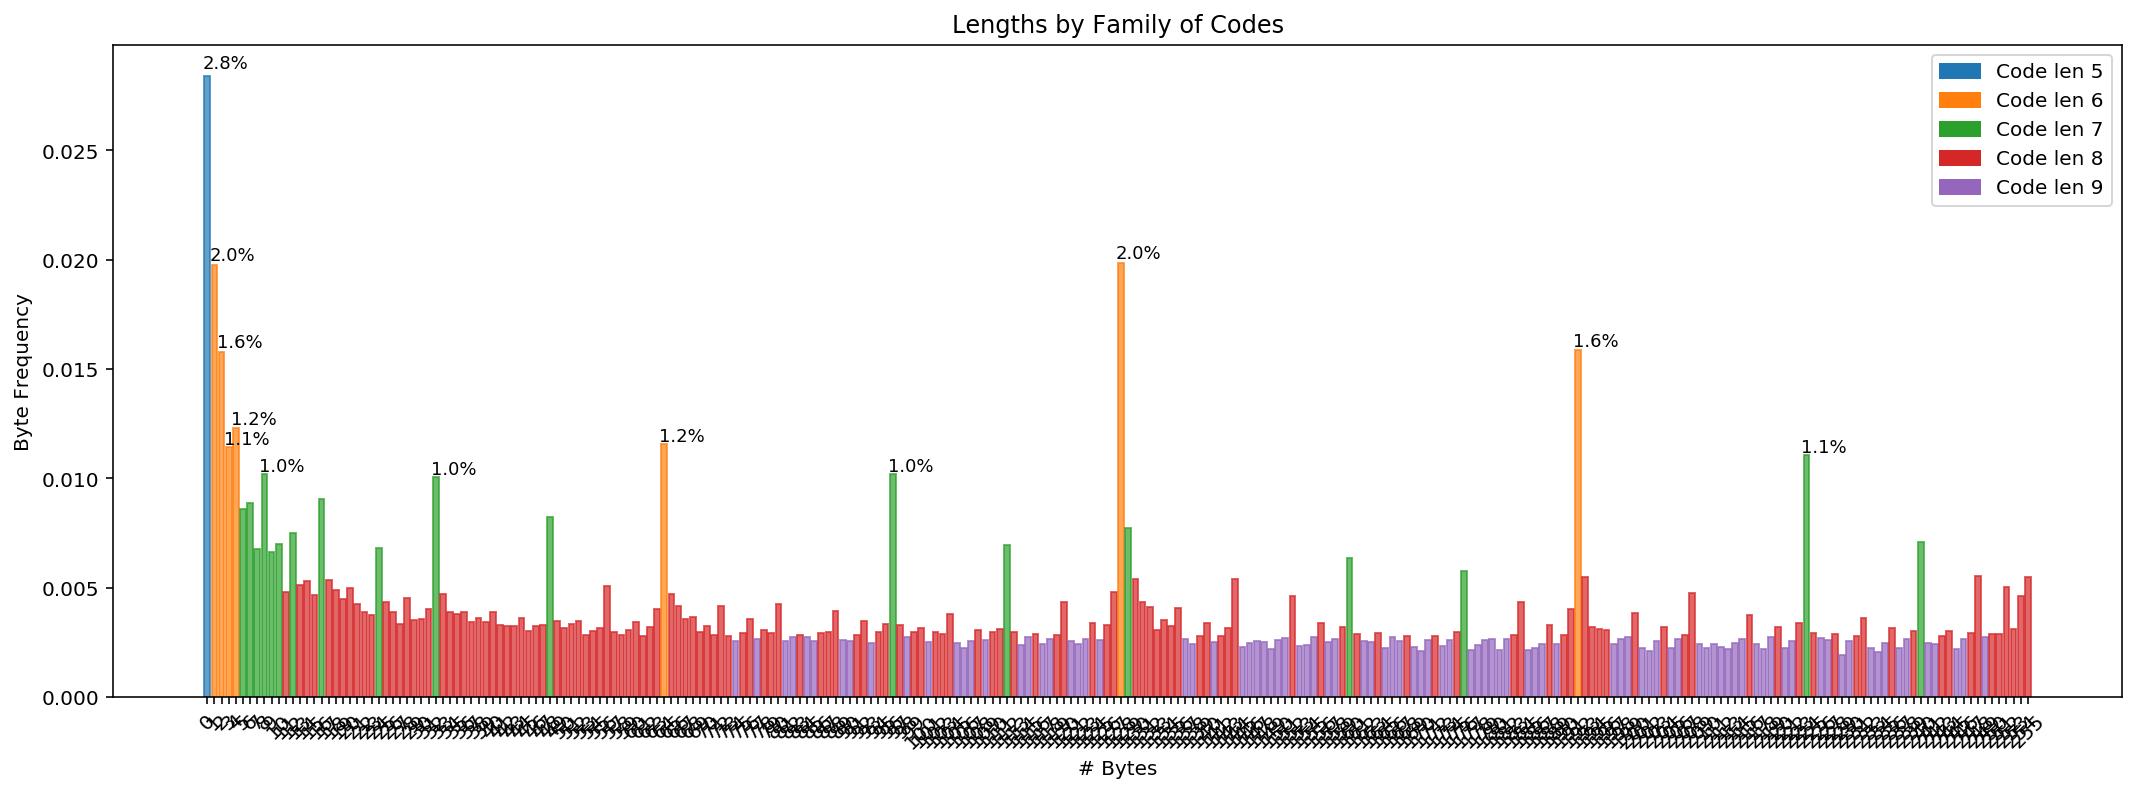

In [28]:
# Create plot
plot_lens_by_codes_families(term_freq, hf_code)

## 3. Compress Text file with Huffman Code

In this example, the compression and decompression functions will be tested with the abstract of an English paper.

In [29]:
# Loading target text book
file_path = "../data/text/abstract1-en.txt"
text_byte_list = get_file_bytes(file_path)

In [30]:
# Alphabet with 256 symbols
term_freq = get_term_freq(text_byte_list)
len(term_freq)

57

In [31]:
# Normalize term frequency
n = sum(term_freq.values())
for term in term_freq:
    term_freq[term] = term_freq[term] / n;
sum(term_freq.values())

1.0000000000000004

In [32]:
# Get Huffman coding
hf_code = hc.get_code(term_freq)

In [33]:
# Create and showing the Huffman codes
codes = create_huffman_df(hf_code, term_freq)
codes.head(20)

,byte,symbol,code,frequency
0,100,d,00010,0.0225989
1,101,e,010,0.104206
2,102,f,00011,0.0225989
3,103,g,001110,0.0138104
4,104,h,10000,0.0301318
5,105,i,1001,0.0684244
6,106,j,001111110,0.00188324
7,107,k,1111010100,0.00125549
8,108,l,00000,0.0213434
9,109,m,111100,0.0194601


In [34]:
# Save full huffman codes as CSV file
codes.to_csv('../huffman_codes/sample2.csv', index=False)

In [35]:
# Calculate weighted message size average
msg_size_current = 8
msg_size_weighted = 0

for key, value in hf_code.items():
    msg_size_weighted += len(value) * term_freq[key]

In [36]:
# Current message size average (bits per symbol)
msg_size_current

8

In [37]:
# Weighted message size average (bits per symbol)
msg_size_weighted

4.369742623979907

### Real compression percentage

In [38]:
# Calculating compression ratio (%)
compress_rate = (msg_size_current - msg_size_weighted) / msg_size_current
print(round(compress_rate * 100, 2), '%')

45.38 %


In [39]:
# Compressing text file with Huffman code
compress_file, symbols_used = compress_bin_file(text_byte_list, hf_code)
print(compress_file[:508])

1111010010110101010000010101101110000111010011111111000110011110110011010111111101000010110001001100001001001011000011000101101111101111110010001001001111111111010011110000111011011111110001101010100110111110110101010111100010001010110011011000100010110111111001001011100011001111011001100100111101000001110101100011110101010000010110100010111010011000111010011111111010110101010000010110001001011000001110111100011010101010010011111001101110000101100101110010011100111000001110011001110100011110110111101110


In [40]:
# Weight of the compressed text file (KB)
print(round(len(compress_file) / 8 / 1024, 2), 'KB')

0.85 KB


In [41]:
# Weight of the original text file (KB)
print(round(len(text_byte_list) / 1024, 2), 'KB')

1.56 KB


### Lengths by Family of Codes

The code family that encoded each byte is plotted below.

In [42]:
# Show frequency of length of used symbols
symbols_used

{3: 413, 4: 645, 5: 339, 6: 95, 7: 35, 8: 6, 9: 24, 10: 28, 11: 8}

In [43]:
# Palette of colores
palette = {"3": "#1f77b4", "4": "#ff7f0e", "5": "#2ca02c", "6": "#d62728", "7": "#9467bd", 
           "8": "#8c564b", "9": "#e377c2", "10": "#7f7f7f", "11": "#bcbd22"}

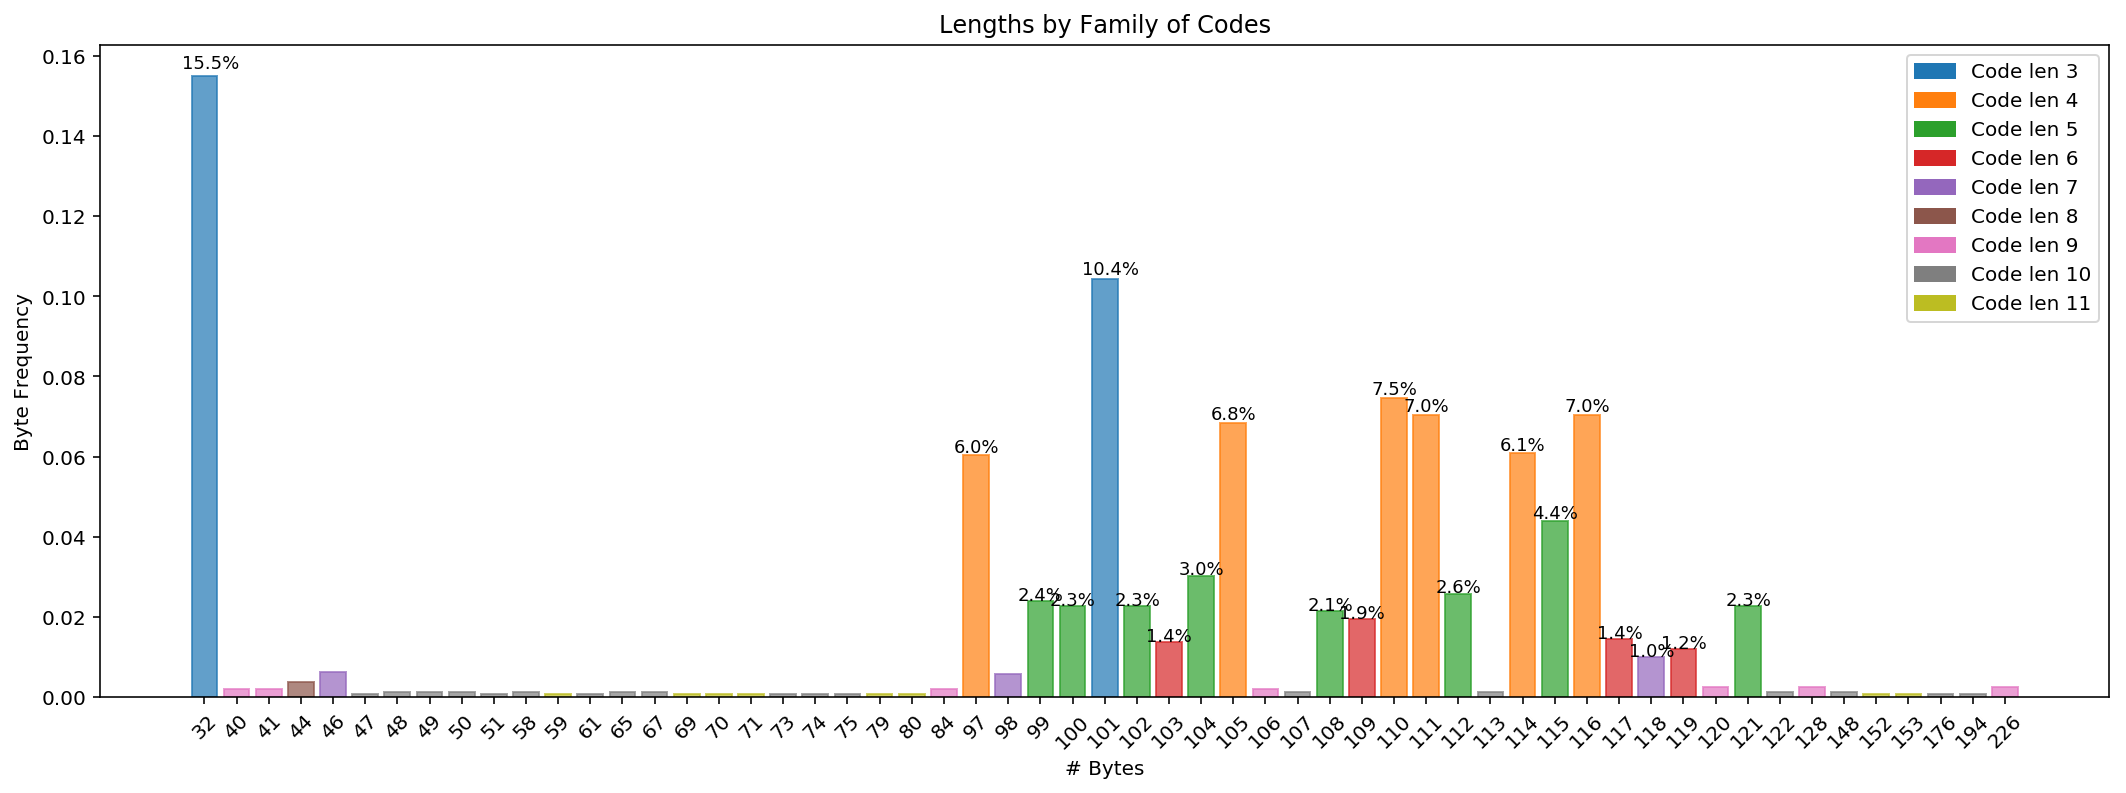

In [44]:
# Create plot
plot_lens_by_codes_families(term_freq, hf_code)

## 4. Decompress file with Huffman Code

### 4.1. Simple approach
Test with all huffman codes until the file is completely decompressed. The codes are sorted ascending by their length.

In [45]:
# Creates a dataframe with the codes, frequency and compression percentage of each of them
def create_codes_df(code_list, hf_code, col_sort):
    term_freq = Counter([len(v) for k, v in hf_code.items()])
    df_codes = pd.DataFrame([code_list, term_freq]).T
    df_codes.reset_index(level=0, inplace=True)
    df_codes.columns = ["code_size", "bytes_compressed", "code_count"]
    df_codes['code_comp_perc'] = round(df_codes.bytes_compressed / df_codes.code_count, 2)
    df_codes = df_codes[["code_size", "code_count", "bytes_compressed", "code_comp_perc"]]
    
    return df_codes.sort_values(by=[col_sort], ascending=False)

In [46]:
# Show frequency of length of used symbols
df = create_codes_df(symbols_used, hf_code, 'code_comp_perc')
df.style.set_table_styles([
    {'selector': '.row_heading, .blank', 'props': [('display', 'none;')]}
])

,code_size,code_count,bytes_compressed,code_comp_perc
0,3,2,413,206.5
1,4,6,645,107.5
2,5,8,339,42.38
3,6,4,95,23.75
4,7,3,35,11.67
5,8,1,6,6
6,9,7,24,3.43
7,10,18,28,1.56
8,11,8,8,1


In [47]:
# Decompress a binary file using a huffman code
def decompress_bin_file(byte_string, hf_code, symb_used):
    start_time = timeit.default_timer()
    byte_list = []
    codes_size = []
    inv_codes = {v: k for k, v in hf_code.items()}
    fails_list = []
    n_size = len(byte_string)
    
    # Sort codes_size list by code length
    for k, v in symb_used.items():
        codes_size.append(k)
    codes_size.sort(reverse = False)
    
    # Decompress
    ix = 0
    while ix < n_size:
        curr_tries = 0
        
        for size in codes_size:
            possible_code = byte_string[ix:ix + size]
            
            if possible_code in inv_codes.keys():
                byte = int(inv_codes[possible_code])
                byte_list.append(byte)
                ix = ix + size
                fails_list.append(curr_tries)
                break
            curr_tries += 1
        
    # Elapsed time
    elapsed = timeit.default_timer() - start_time
    
    # Algorithm accuracy
    total_tries = sum(fails_list)
    algo_accuracy = round(100 * len(byte_list) / total_tries, 2)
    
    # Verbose
    print(codes_size)
    print('elapsed time', elapsed, 's')
    print('tries:', total_tries, ', acurracy:', algo_accuracy, '%')
    
    return byte_list, fails_list, codes_size;

In [48]:
# Decode/Decompress file using the Huffman code
decompress_file, fails_list, codes_size = decompress_bin_file(compress_file, hf_code, symbols_used)

[3, 4, 5, 6, 7, 8, 9, 10, 11]
elapsed time 0.0041066 s
tries: 2182 , acurracy: 73.01 %


In [49]:
# Weight of the original text file (KB)
print(round(len(decompress_file) / 1024, 2), 'KB')

1.56 KB


#### Comparing if the original file and the decompressed file are the same (equals)

In [50]:
# Compare if two files are equals for equality and element-wise
def compare_files(file_a, file_b):
    return np.array_equiv(file_a, file_b)

In [51]:
# Comparing files
compare_files(text_byte_list, decompress_file)

True

#### Show fails behavior during decompression

In [52]:
# Function that plots the fails behavior of the decompression process
def plot_fails_behavior(f_data):
    
    # Average failures per decompressed byte
    f_mean = stats.mean(f_data)
    f_stdev = stats.pstdev(f_data)
    print(round(f_mean, 4), 'fails/byte with a std dev:', round(f_stdev, 4))
    
    max_value = max(f_data)
    min_value = 0
    upper_lim = min(max_value, (f_mean + f_stdev))
    lower_lim = max(min_value, (f_mean - f_stdev))
    
    fig = plt.figure(figsize = (16, 6))
    plt.plot(f_data)
    plt.axhline(y = upper_lim, color = "#8b0000", linestyle = "--")
    plt.axhline(y = f_mean, color = "#8b0000", linestyle = "-")
    plt.axhline(y = lower_lim, color = "#8b0000", linestyle = "--")
    plt.title('The behavior of fails during decompression')
    plt.xlabel('# Bytes', fontsize = 10)
    plt.ylabel('Count of failures', fontsize = 10)
    plt.show()

1.3697 fails/byte with a std dev: 1.4448


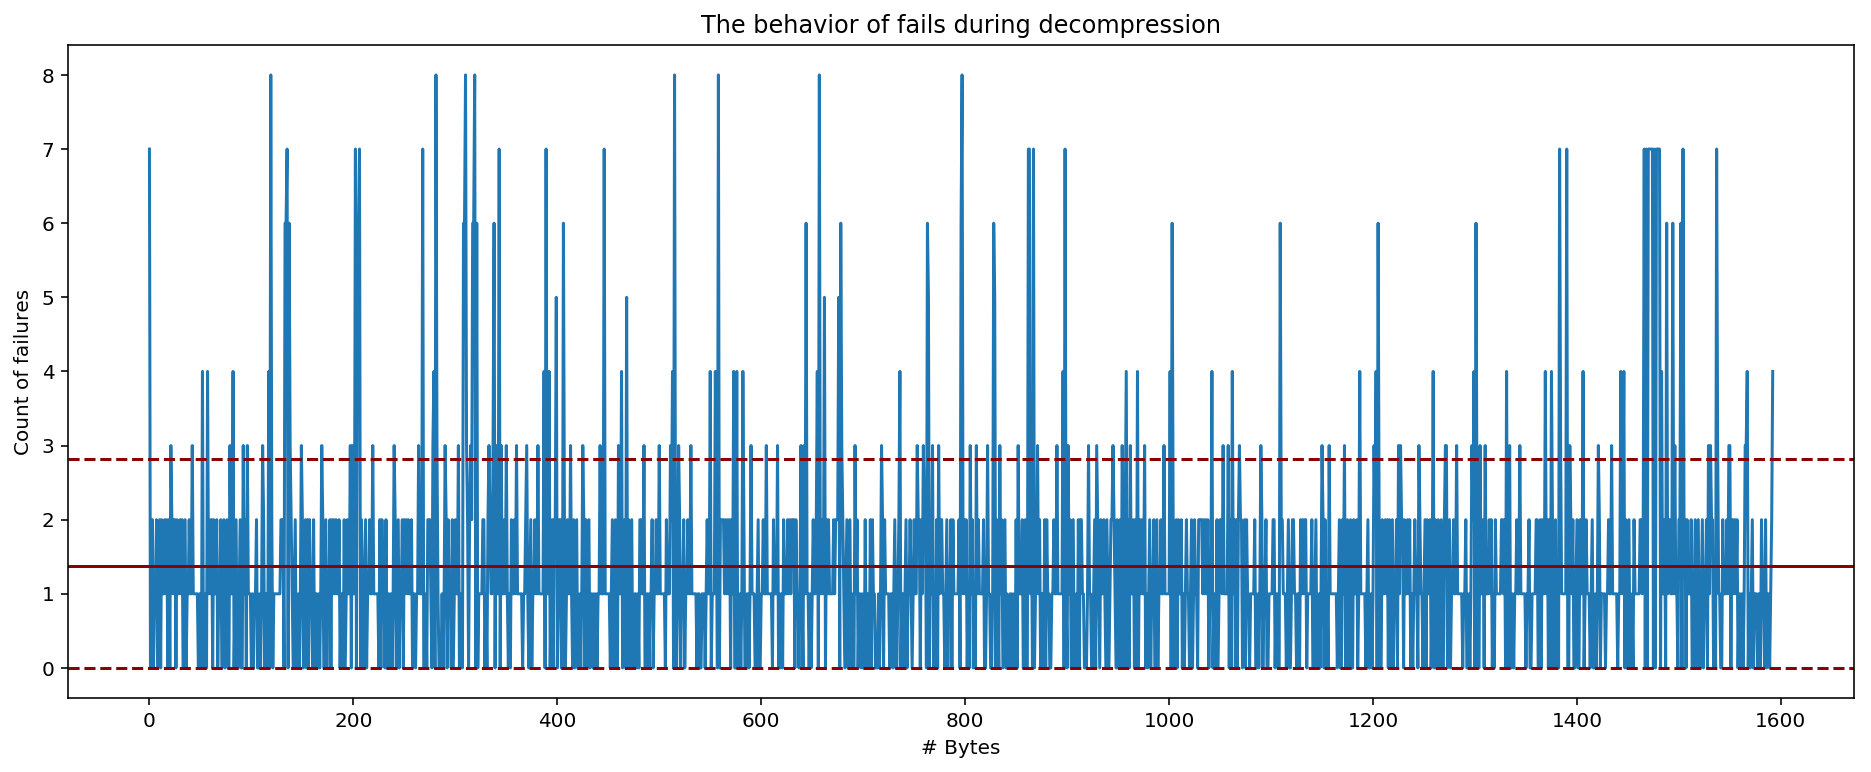

In [53]:
# Plotting the fails behavior
plot_fails_behavior(fails_list)

In [54]:
# Function that calculates distribution of the number of fails
def calc_fails_dist(f_data):
    fails_dist = Counter(f_data)
    df_fails_dist = pd.DataFrame.from_records(fails_dist.most_common(), columns = ['n_fails', 'quantity'])
    df_fails_dist["fails_perc"] = 100 * df_fails_dist.quantity / len(fails_list)
    df_fails_dist = df_fails_dist.sort_values(by=['n_fails'])
    return df_fails_dist

In [55]:
# Calculate distribution of the number of fails
df_fails_dist = calc_fails_dist(fails_list)
df_fails_dist

,n_fails,quantity,fails_perc
1,0,413,25.925926
0,1,645,40.489642
2,2,339,21.280603
3,3,95,5.963591
4,4,35,2.197112
8,5,6,0.376648
6,6,24,1.506591
5,7,28,1.757690
7,8,8,0.502197


In [56]:
# Function that plots the distribution of fails
def plot_fails_dist(f_list, df_f_dist, c_sizes):
    fig = plt.figure(figsize = (18, 6))
    fig.subplots_adjust(hspace = 0.15, wspace = 0.15)
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 3]) 
    
    ax0 = plt.subplot(gs[0])
    sns.violinplot(y=f_list)
    ax0.set_ylabel('# Fails', fontsize = 10)
    
    colors = [] 
    for size in c_sizes:
        colors.append(palette[str(size)])
    
    ax1 = plt.subplot(gs[1])
    g = sns.barplot(x = 'n_fails', y = 'quantity', data = df_f_dist, palette=colors)
    for index, row in df_f_dist.iterrows():
        lbl_value = str(round(row.fails_perc, 2)) + ' %'
        g.text(row.n_fails, row.quantity * 1.01, lbl_value, color='black', ha="center")
    ax1.set_xlabel('# Fails', fontsize = 10)
    ax1.set_ylabel('Number of fails', fontsize = 12)
    
    fig.suptitle('Distribution of the number of failures')
    plt.show()

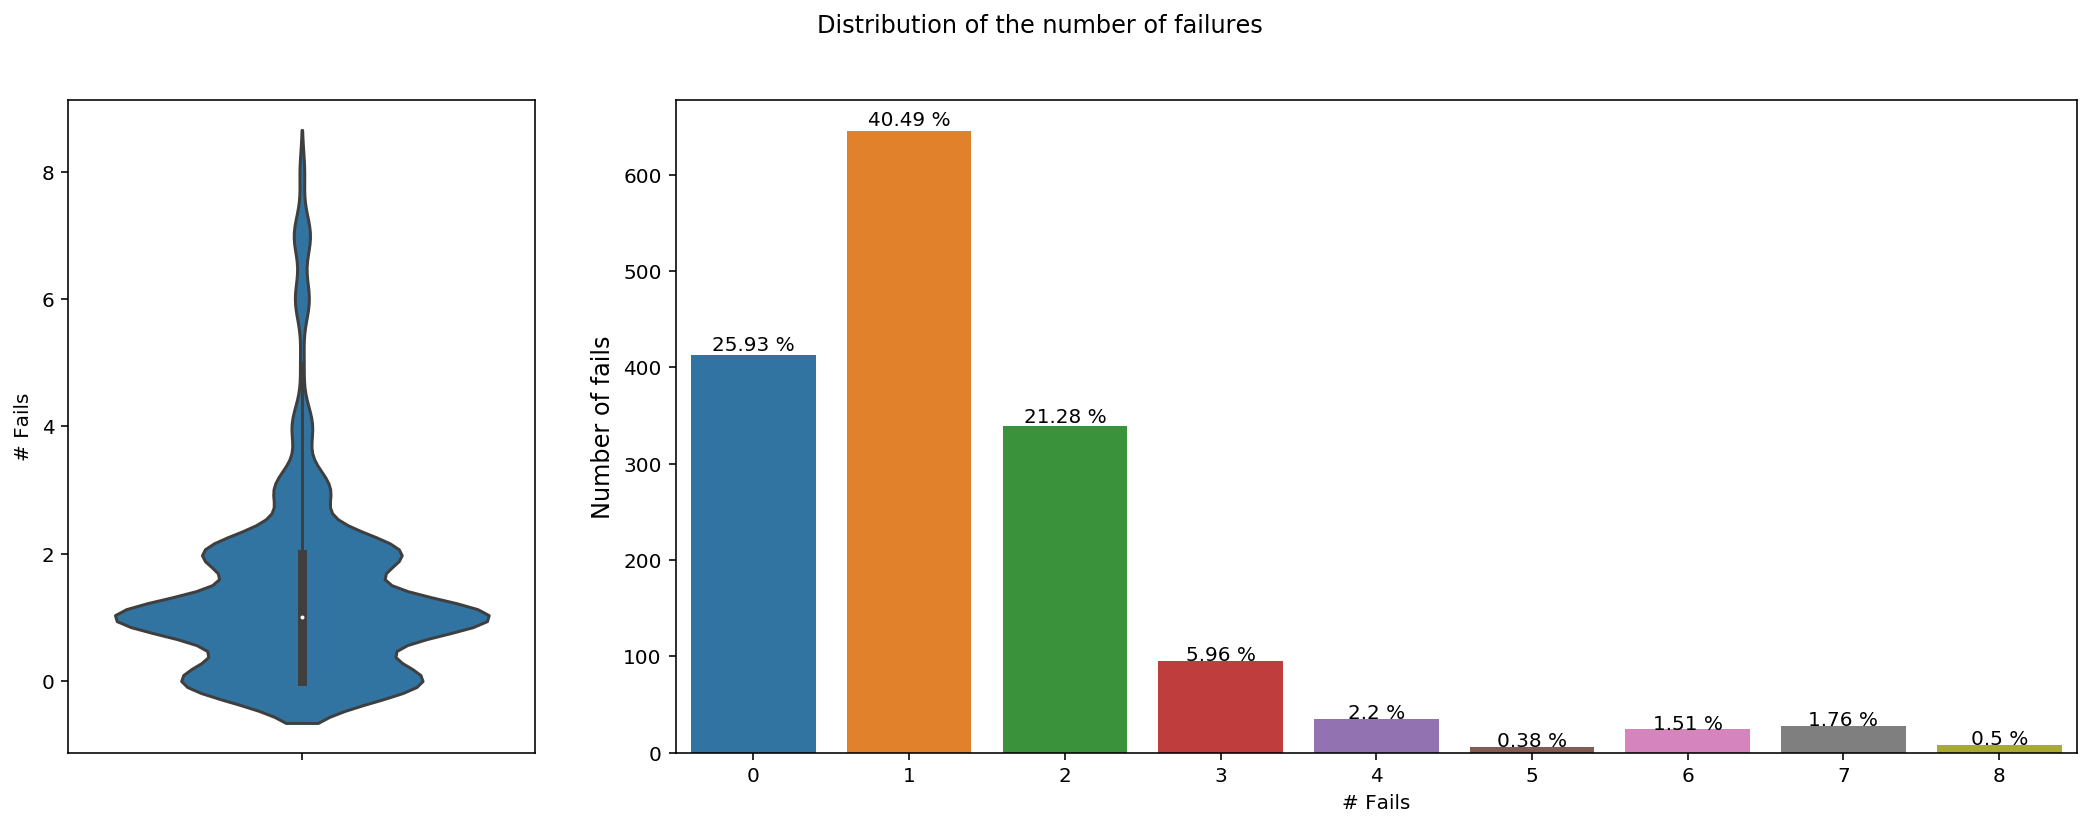

In [57]:
# Plotting the distribution of fails
plot_fails_dist(fails_list, df_fails_dist, codes_size)

### 4.2. Probabilistic approach

Based on the probability of occurrence of each family of symbols...

In [58]:
# Sort dict by probability of occurrence
symbols_used_sort = dict(sorted(symbols_used.items(), key=lambda kv: kv[1], reverse=True))

In [59]:
# Show frequency of length of used symbols
df = create_codes_df(symbols_used_sort, hf_code, 'bytes_compressed')
df.style.set_table_styles([
    {'selector': '.row_heading, .blank', 'props': [('display', 'none;')]}
])

,code_size,code_count,bytes_compressed,code_comp_perc
1,4,6,645,107.5
0,3,2,413,206.5
2,5,8,339,42.38
3,6,4,95,23.75
4,7,3,35,11.67
7,10,18,28,1.56
6,9,7,24,3.43
8,11,8,8,1
5,8,1,6,6


In [60]:
# Decompress a binary file using a huffman code
def decompress_bin_file_prob(byte_string, hf_code, symb_used):
    start_time = timeit.default_timer()
    byte_list = []
    codes_size = []
    inv_codes = {v: k for k, v in hf_code.items()}
    fails_list = []
    n_size = len(byte_string)
    
    # Sort codes_size list by the probability of the code family
    prob_symbols = sorted(symb_used.items(), key=lambda kv: kv[1], reverse=True)
    for k, v in prob_symbols:
        codes_size.append(k)
    
    # Decompress
    ix = 0
    while ix < n_size:
        curr_tries = 0
        
        for size in codes_size:
            possible_code = byte_string[ix:ix + size]
            
            if possible_code in inv_codes.keys():
                byte = int(inv_codes[possible_code])
                byte_list.append(byte)
                ix = ix + size
                fails_list.append(curr_tries)
                break
            curr_tries += 1
        
    # Elapsed time
    elapsed = timeit.default_timer() - start_time
    
    # Algorithm accuracy
    total_tries = sum(fails_list)
    algo_accuracy = round(100 * len(byte_list) / total_tries, 2)
    
    # Verbose
    print(codes_size)
    print('elapsed time', elapsed, 's')
    print('tries:', total_tries, ', acurracy:', algo_accuracy, '%')
    
    return byte_list, fails_list, codes_size;

In [61]:
# Decode/Decompress file using the Huffman code
decompress_file2, fails_list2, codes_size2 = decompress_bin_file_prob(compress_file, hf_code, symbols_used)

[4, 3, 5, 6, 7, 10, 9, 11, 8]
elapsed time 0.004494800000000021 s
tries: 1904 , acurracy: 83.67 %


In [62]:
# Weight of the original text file (KB)
print(round(len(decompress_file2) / 1024, 2), 'KB')

1.56 KB


In [63]:
# Comparing files
compare_files(text_byte_list, decompress_file2)

True

#### Show fails behavior during decompression

1.1952 fails/byte with a std dev: 1.428


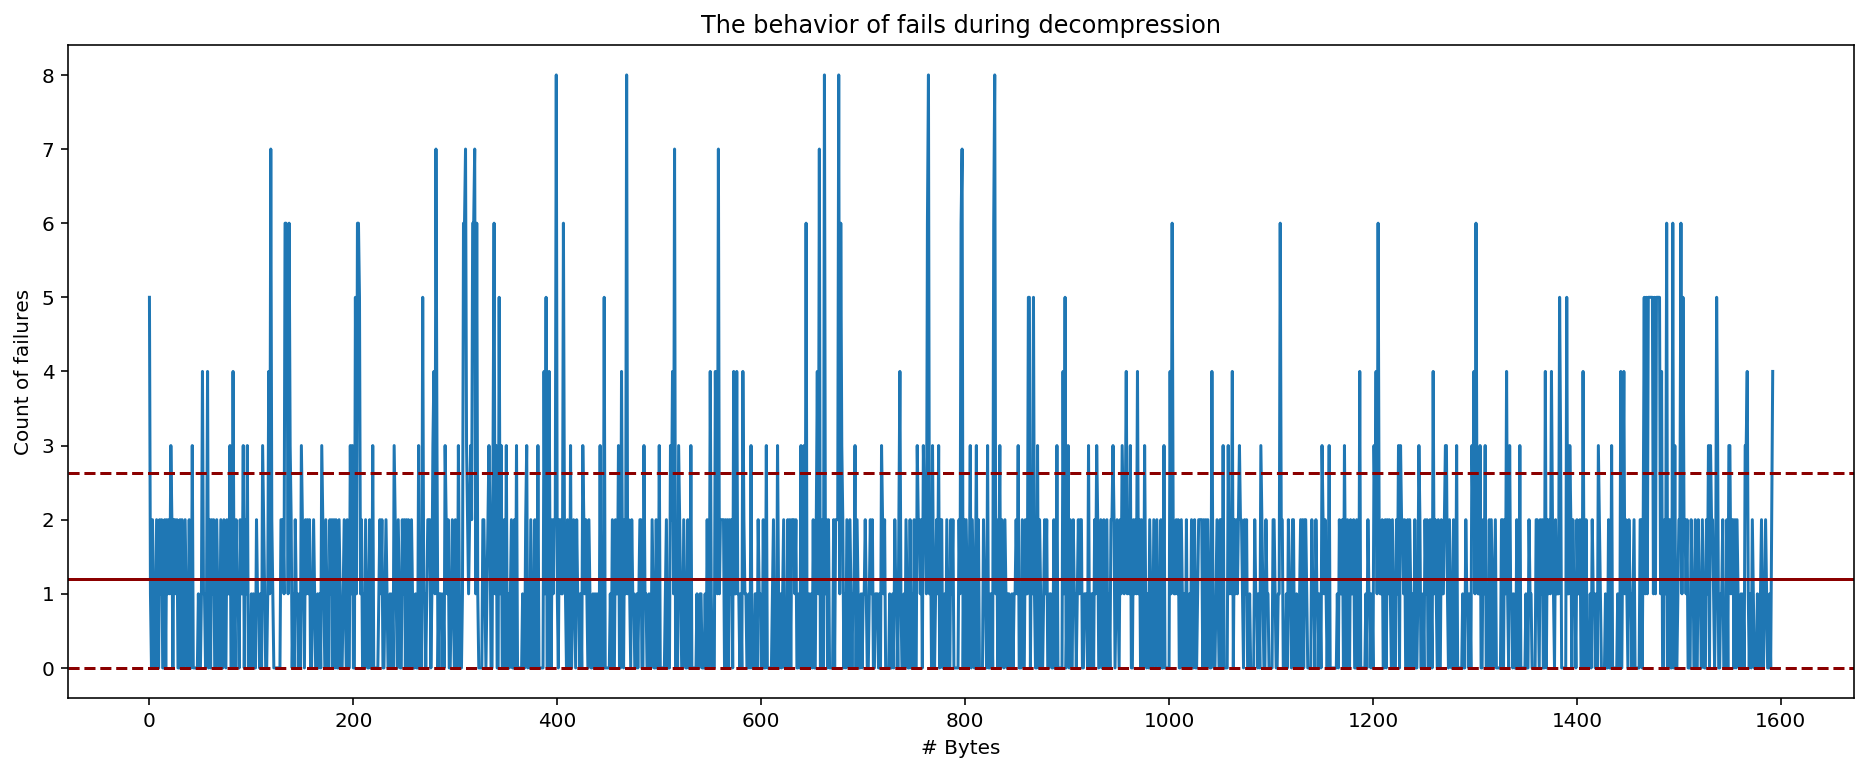

In [64]:
# Plotting the fails behavior
plot_fails_behavior(fails_list2)

In [65]:
# Calculate distribution of the number of fails
df_fails_dist2 = calc_fails_dist(fails_list2)
df_fails_dist2

,n_fails,quantity,fails_perc
0,0,645,40.489642
1,1,413,25.925926
2,2,339,21.280603
3,3,95,5.963591
4,4,35,2.197112
5,5,28,1.757690
6,6,24,1.506591
7,7,8,0.502197
8,8,6,0.376648


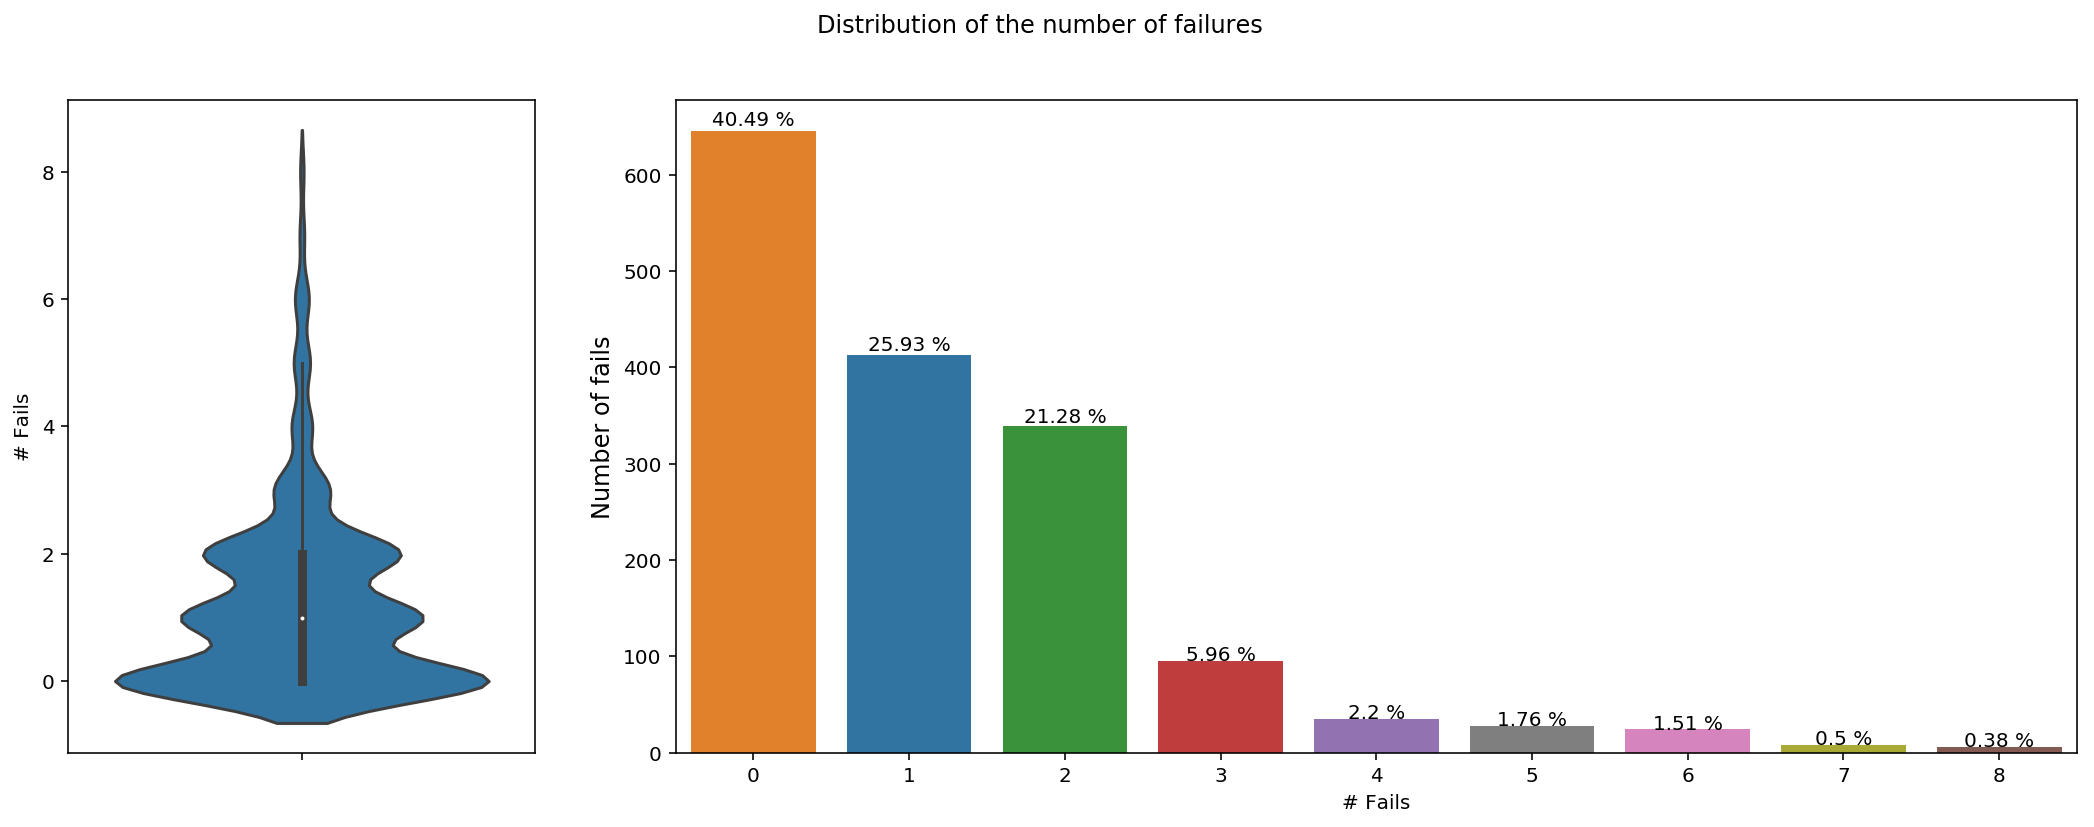

In [66]:
# Plotting the distribution of fails
plot_fails_dist(fails_list2, df_fails_dist2, codes_size2)

**Conclusion**

Using the size of the most likely symbols as cutting length improves both the accuracy (from 73.01 % to 83.67 %) and the time it takes for the decompression process.

### 4.3. Pseudo-random approach

Testing with selected pseudo-random huffman codes, based on their probability of occurrence <a href="#link_two">[2]</a>. The objective is not to improve previous implementations, but to propose another way to solve the same problem.

In [67]:
# Class Probabilistic Huffman Code from scratch
class ProbHCodes:
    
    # Constructor
    def __init__(self):
        self.prob_table = []
        self.n_rows = 0
        self.last_ix = -1
    
    # Returns the probabilistic codes table
    def get_prob_table(self):
        return self.prob_table
    
    # Function that creates the table with the the probability of use of codes in the decompression process
    def create_prob_table(self, symbols):
        self.total = sum(symbols.values())
        cum = 0

        for key, value in symbols.items():
            curr = value / self.total
            cum += curr
            item = [key, value, curr, cum]
            self.prob_table.append(item)
        
        self.n_rows = len(self.prob_table)
        self.prob_table[self.n_rows - 1][3] = 1.0
    
    # Function that returns the size and index of the selected code
    def get_prob_code(self):
        prn = np.random.uniform(0, 1)
        
        while True:
            for ix in range(self.n_rows):
                item = self.prob_table[ix]
                if prn <= item[3]:
                    if ix == self.last_ix:
                        break
                    self.last_ix = ix
                    return item[0], ix
            prn = np.random.uniform(0, 1)
    
    # Function that updates the probability of use of codes
    def update_prob_table(self, ix_code):
        
        if self.prob_table[ix_code][1] > 1:
            self.prob_table[ix_code][1] -= 1
        else:
            self.prob_table.remove(self.prob_table[ix_code])
            self.n_rows -= 1
        self.total -= 1

        cum = 0
        for row in self.prob_table:
            curr = row[1] / self.total
            cum += curr
            row[2] = curr
            row[3] = cum

In [68]:
# Decompress a binary file using a huffman code
def decompress_bin_file_rnd(byte_string, hf_code, symbols_used):
    start_time = timeit.default_timer()
    
    byte_list = []
    n_size = len(byte_string)
    inv_codes = {v: k for k, v in hf_code.items()}
    
    # Create Probabilistic Huffman Codes table
    phc = ProbHCodes()
    phc.create_prob_table(symbols_used)
    
    # Get code based on probability
    size, ix_code = phc.get_prob_code()
    
    ix = 0
    tries = 0
    while ix < n_size:
        
        while True:
            tries += 1
            possible_code = byte_string[ix:ix + size]
            
            if possible_code in inv_codes.keys():
                byte = int(inv_codes[possible_code])
                byte_list.append(byte)
                ix = ix + size
                break
            
            # Get code based on probability
            size, ix_code = phc.get_prob_code()
    
    # Elapsed time
    elapsed = timeit.default_timer() - start_time
    
    # Algorithm accuracy
    algo_accuracy = round(100 * len(byte_list) / tries, 2)
    
    # Verbose
    print('elapsed time', elapsed, 's')
    print('tries:', tries, ', acurracy:', algo_accuracy, '%')
    
    return byte_list;

In [69]:
# Context
print('hf_code len:', len(hf_code), ', symbols_used:', len(symbols_used))

hf_code len: 57 , symbols_used: 9


In [70]:
# Decode/Decompress file using the Huffman code
decompress_file3 = decompress_bin_file_rnd(compress_file, hf_code, symbols_used)

elapsed time 0.07529079999999988 s
tries: 9386 , acurracy: 16.97 %


In [71]:
# Weight of the original text file (KB)
print(round(len(decompress_file3) / 1024, 2), 'KB')

1.56 KB


#### Comparing if the original file and the decompressed file are the same (equals)

In [72]:
# Comparing files
compare_files(text_byte_list, decompress_file3)

True

## References

<a name='link_one' href='https://en.wikipedia.org/wiki/Huffman_coding' target='_blank' >[1]</a> Wikipedia - Huffman coding.  
<a name='link_two' href='https://en.wikipedia.org/wiki/Randomized_algorithm' target='_blank' >[2]</a> Wikipedia - Randomized algorithm.  

<hr>
<p><a href="https://ansegura7.github.io/DataCompression/">« Home</a></p>